In [1]:
!pip install transformers datasets rouge_score nltk rouge_score
!pip install rouge_score
!pip install datasets

In [23]:
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, T5ForConditionalGeneration, GPT2LMHeadModel
from datasets import load_dataset
import numpy as np
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics import f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the dataset
dataset = load_dataset('toughdata/quora-question-answer-dataset', split='train[:1000]')
df = pd.DataFrame(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/56402 [00:00<?, ? examples/s]

In [4]:
# Initialize models and tokenizers
bert_tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
bert_model = AutoModelForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

t5_tokenizer = AutoTokenizer.from_pretrained('t5-base')
t5_model = T5ForConditionalGeneration.from_pretrained('t5-base')

gpt_tokenizer = AutoTokenizer.from_pretrained('gpt2')
gpt_model = GPT2LMHeadModel.from_pretrained('gpt2')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [5]:
# Initialize ROUGE scorer
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def preprocess_function(examples):
    return {
        'question': examples['question'],
        'context': examples['answer'],
        'answer': examples['answer']
    }

dataset = dataset.map(preprocess_function)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [6]:
# Helper functions for each model
def bert_qa(question, context):
    inputs = bert_tokenizer(question, context, return_tensors='pt', truncation=True, max_length=512)
    outputs = bert_model(**inputs)
    answer_start = torch.argmax(outputs.start_logits)
    answer_end = torch.argmax(outputs.end_logits) + 1
    answer = bert_tokenizer.convert_tokens_to_string(bert_tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
    return answer

In [7]:
def t5_qa(question, context):
    input_text = f"question: {question} context: {context}"
    input_ids = t5_tokenizer(input_text, return_tensors='pt', max_length=512, truncation=True).input_ids
    outputs = t5_model.generate(input_ids, max_length=64)
    return t5_tokenizer.decode(outputs[0], skip_special_tokens=True)

In [30]:
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)


In [31]:
def gpt_qa(question, context):
    input_text = f"Question: {question}\nContext: {context}\nAnswer:"
    input_ids = gpt_tokenizer.encode(input_text, return_tensors='pt', truncation=True, max_length=1024)
    try:
        outputs = gpt_model.generate(input_ids, max_new_tokens=50, num_return_sequences=1, pad_token_id=gpt_tokenizer.eos_token_id)
        return gpt_tokenizer.decode(outputs[0], skip_special_tokens=True)
    except Exception as e:
        print(f"Error in GPT generation: {e}")
        return ""

In [9]:
# Evaluation function
def evaluate_model(model_func, dataset, num_samples=100):
    rouge_scores = []
    bleu_scores = []
    f1_scores = []

    for i in range(min(num_samples, len(dataset))):
        question = dataset[i]['question']
        context = dataset[i]['context']
        true_answer = dataset[i]['answer']

        predicted_answer = model_func(question, context)

        # ROUGE score
        rouge_score = rouge_scorer.score(true_answer, predicted_answer)
        rouge_scores.append((rouge_score['rouge1'].fmeasure + rouge_score['rouge2'].fmeasure + rouge_score['rougeL'].fmeasure) / 3)

        # BLEU score
        bleu_score = sentence_bleu([true_answer.split()], predicted_answer.split())
        bleu_scores.append(bleu_score)

        # F1 score (treat as binary classification problem)
        f1 = f1_score([1], [1 if predicted_answer.lower() in true_answer.lower() else 0], average='binary')
        f1_scores.append(f1)

    return {
        'ROUGE': np.mean(rouge_scores),
        'BLEU': np.mean(bleu_scores),
        'F1': np.mean(f1_scores)
    }


In [11]:
# Evaluate models
bert_results = evaluate_model(bert_qa, dataset)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [15]:
t5_results = evaluate_model(t5_qa, dataset)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [33]:
gpt_results = evaluate_model(gpt_qa, dataset)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Error in GPT generation: index out of range in self


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [34]:
# Combine results
results_df = pd.DataFrame({
    'BERT': bert_results,
    'T5': t5_results,
    'GPT': gpt_results
}).T



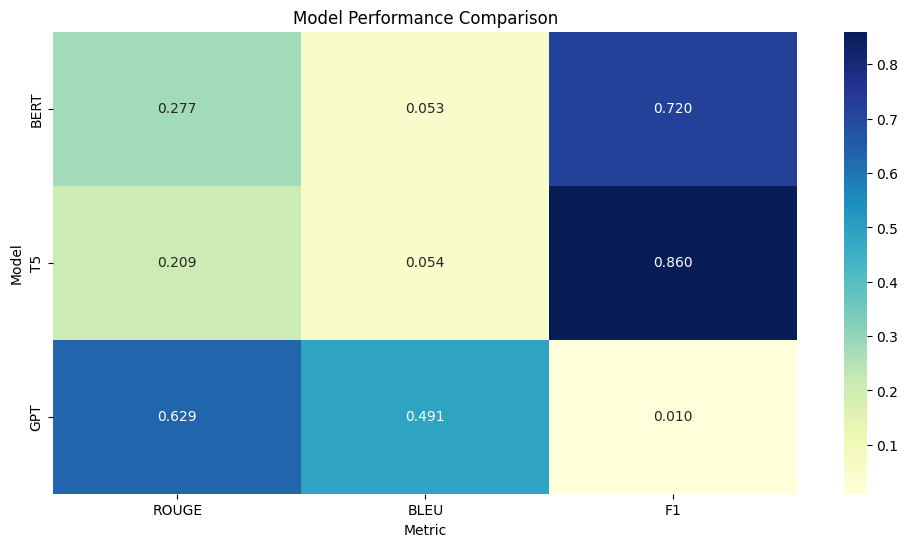

In [35]:
# Visualize results
plt.figure(figsize=(12, 6))
sns.heatmap(results_df, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Model Performance Comparison')
plt.ylabel('Model')
plt.xlabel('Metric')
plt.show()

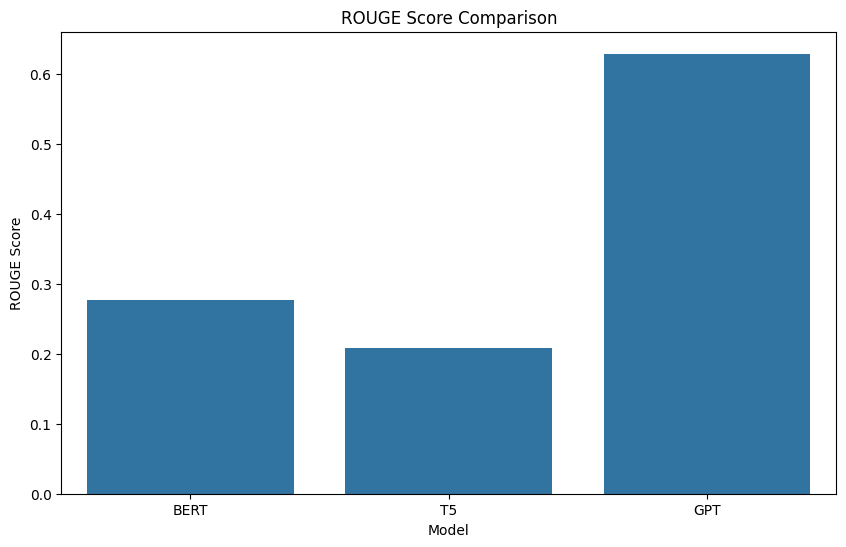

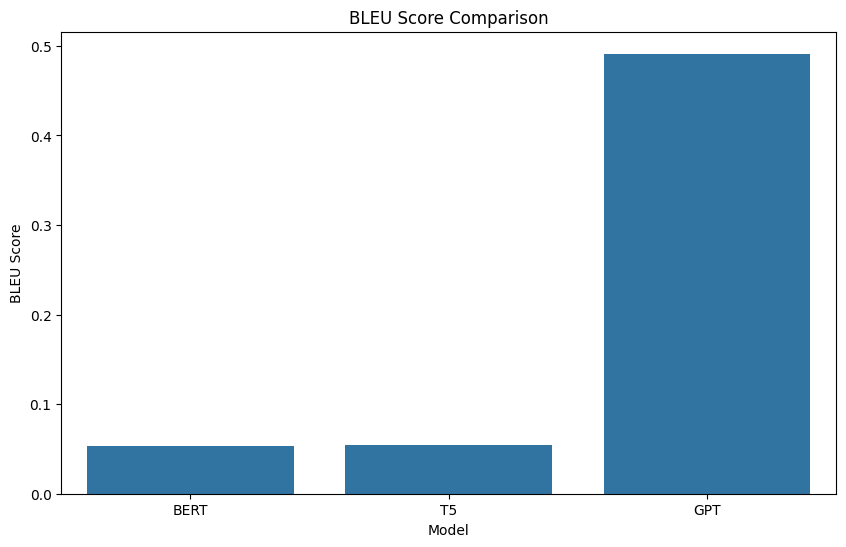

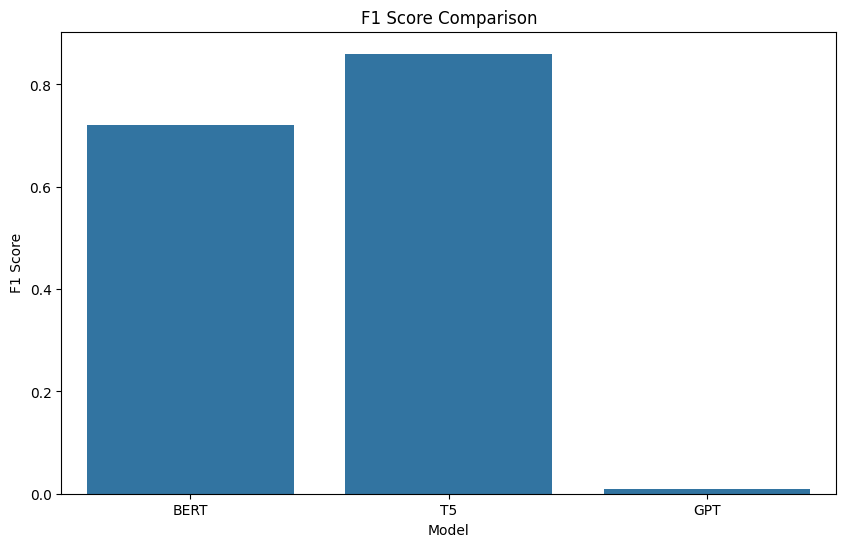

In [36]:
# Bar plot for each metric
metrics = ['ROUGE', 'BLEU', 'F1']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=results_df.index, y=results_df[metric])
    plt.title(f'{metric} Score Comparison')
    plt.ylabel(f'{metric} Score')
    plt.xlabel('Model')
    plt.show()

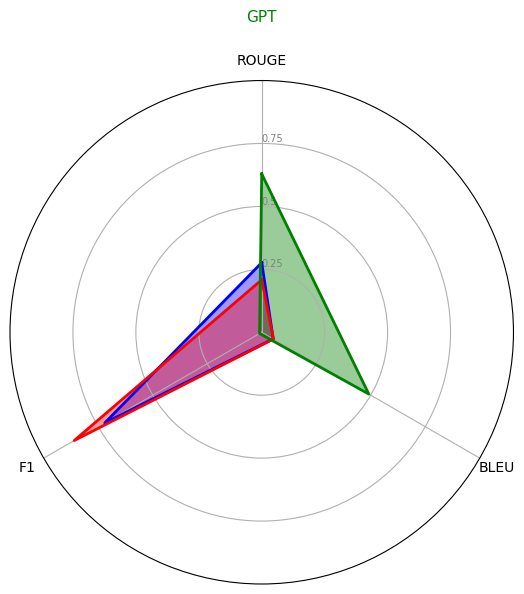

         ROUGE      BLEU    F1
BERT  0.276604  0.052830  0.72
T5    0.208547  0.053888  0.86
GPT   0.628899  0.491251  0.01


In [37]:
# Radar plot for overall comparison
def make_spider(row, title, color):
    categories = list(row.index)
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories)
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=7)
    plt.ylim(0, 1)

    values = row.values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    plt.title(title, size=11, color=color, y=1.1)

plt.figure(figsize=(14, 6))
make_spider(results_df.loc['BERT'], 'BERT', 'blue')
make_spider(results_df.loc['T5'], 'T5', 'red')
make_spider(results_df.loc['GPT'], 'GPT', 'green')
plt.tight_layout()
plt.show()

print(results_df)